In [1]:
from glob import glob
import numpy as np
from matplotlib import pylab as plt
import cv2
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import time
import os

1.10.0


In [2]:
def load_data(batch_size):
    path1=sorted(glob('./facade/test_picture/*'))
    path2=sorted(glob('./facade/test_label/*'))
    i=np.random.randint(0,27)
    batch1=path1[i*batch_size:(i+1)*batch_size]
    batch2=path2[i*batch_size:(i+1)*batch_size]
    
    img_A=[]
    img_B=[]
    for filename1,filename2 in zip(batch1,batch2):
        img1=cv2.imread(filename1)
        img2=cv2.imread(filename2)
        img1=img1[...,::-1]
        img2=img2[...,::-1]
        img1=cv2.resize(img1,(256,256),interpolation=cv2.INTER_AREA)
        img2=cv2.resize(img2,(256,256),interpolation=cv2.INTER_AREA)
        img_A.append(img1)
        img_B.append(img2)
      
    img_A=np.array(img_A)/127.5-1
    img_B=np.array(img_B)/127.5-1
    
    return img_A,img_B 

In [3]:
def load_batch(batch_size):
    path1=sorted(glob('./facade/train_picture/*'))
    path2=sorted(glob('./facade/train_label/*'))
    n_batches=int(len(path1)/batch_size)
  
    for i in range(n_batches):
        batch1=path1[i*batch_size:(i+1)*batch_size]
        batch2=path2[i*batch_size:(i+1)*batch_size]
        img_A,img_B=[],[]
        for filename1,filename2 in zip(batch1,batch2):
            img1=cv2.imread(filename1)
            img2=cv2.imread(filename2)
            img1=img1[...,::-1]
            img2=img2[...,::-1]
            img1=cv2.resize(img1,(256,256),interpolation=cv2.INTER_AREA)    
            img2=cv2.resize(img2,(256,256),interpolation=cv2.INTER_AREA)
            img_A.append(img1)#picture
            img_B.append(img2)#label
      
        img_A=np.array(img_A)/127.5-1
        img_B=np.array(img_B)/127.5-1
    
        yield img_A,img_B #return generator

In [4]:
class pix2pix():
    def __init__(self):
        self.img_rows=256
        self.img_cols=256
        self.channels=3
        self.img_shape=(self.img_rows,self.img_cols,self.channels)
    
        patch=int(self.img_rows/(2**4)) # 16
        self.disc_patch=(patch,patch,1)
    
        self.gf=64
        self.df=64
    
        optimizer=tf.keras.optimizers.Adam(0.0002,0.5)
    
        self.discriminator=self.build_discriminator()
        #self.discriminator.summary()
        self.discriminator.compile(loss='binary_crossentropy',
                              optimizer=optimizer)
    
        self.generator=self.build_generator()
        #self.generator.summary()
    
        img_A=layers.Input(shape=self.img_shape)#picture--label
        img_B=layers.Input(shape=self.img_shape)#label--real
    
        img=self.generator(img_A)
    
        self.discriminator.trainable=False
    
        valid=self.discriminator([img,img_A])
    
        self.combined=Model(img_A,valid)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=optimizer)
    
    def build_generator(self):
        def conv2d(layer_input,filters,f_size=(4,4),bn=True):
            d=layers.Conv2D(filters,kernel_size=f_size,strides=(2,2),padding='same')(layer_input)
            d=layers.LeakyReLU(0.2)(d)
            if bn:
                d=layers.BatchNormalization()(d)
            return d
    
        def deconv2d(layer_input,skip_input,filters,f_size=(4,4),dropout_rate=0):
            u=layers.UpSampling2D((2,2))(layer_input)
            u=layers.Conv2D(filters,kernel_size=f_size,strides=(1,1),padding='same',activation='relu')(u)
            if dropout_rate:
                u=layers.Dropout(dropout_rate)(u)
            u=layers.BatchNormalization()(u)
            u=layers.Concatenate()([u,skip_input])
            return u
    
        d0=layers.Input(shape=self.img_shape)
    
        d1=conv2d(d0,self.gf,bn=False) 
        d2=conv2d(d1,self.gf*2)         
        d3=conv2d(d2,self.gf*4)         
        d4=conv2d(d3,self.gf*8)         
        d5=conv2d(d4,self.gf*8)         
        d6=conv2d(d5,self.gf*8)        
    
        d7=conv2d(d6,self.gf*8)         
    
        u1=deconv2d(d7,d6,self.gf*8,dropout_rate=0.5)   
        u2=deconv2d(u1,d5,self.gf*8,dropout_rate=0.5)   
        u3=deconv2d(u2,d4,self.gf*8,dropout_rate=0.5)   
        u4=deconv2d(u3,d3,self.gf*4)   
        u5=deconv2d(u4,d2,self.gf*2)   
        u6=deconv2d(u5,d1,self.gf)     
        u7=layers.UpSampling2D((2,2))(u6)
    
        output_img=layers.Conv2D(self.channels,kernel_size=(4,4),strides=(1,1),padding='same',activation='tanh')(u7)
    
        return Model(d0,output_img)
  
    def build_discriminator(self):
        def d_layer(layer_input,filters,f_size=(4,4),bn=True):
            d=layers.Conv2D(filters,kernel_size=f_size,strides=(2,2),padding='same')(layer_input)
            d=layers.LeakyReLU(0.2)(d)
            if bn:
                d=layers.BatchNormalization()(d)
            return d
    
        img_A=layers.Input(shape=self.img_shape)
        img_B=layers.Input(shape=self.img_shape)
    
        combined_imgs=layers.Concatenate(axis=-1)([img_A,img_B])
    
        d1=d_layer(combined_imgs,self.df,bn=False)
        d2=d_layer(d1,self.df*2)
        d3=d_layer(d2,self.df*4)
        d4=d_layer(d3,self.df*8)
    
        validity=layers.Conv2D(1,kernel_size=(4,4),strides=(1,1),padding='same',activation='sigmoid')(d4)
    
        return Model([img_A,img_B],validity)
  
    def train(self,epochs,batch_size=1):
        valid=np.ones((batch_size,)+self.disc_patch)
        fake=np.zeros((batch_size,)+self.disc_patch)
    
        for epoch in range(epochs):
            start=time.time()
            for batch_i,(img_A,img_B) in enumerate(load_batch(1)):
                gen_imgs=self.generator.predict(img_A)
        
                d_loss_real = self.discriminator.train_on_batch([img_B, img_A], valid)
                d_loss_fake = self.discriminator.train_on_batch([gen_imgs, img_A], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
                g_loss = self.combined.train_on_batch(img_A,valid)

                if batch_i % 50 == 0:
                    print ("[Epoch %d] [Batch %d] [D loss: %f] [G loss: %f]" % (epoch,
                                                                                batch_i,
                                                                                d_loss,
                                                                                g_loss))
            
            self.sample_images(epoch)
            print('Time for epoch {} is {} sec'.format(epoch,time.time()-start))
      
    def sample_images(self, epoch):
        r, c = 3, 3
        img_A, img_B =load_data(3)
        fake_A = self.generator.predict(img_A)

        gen_imgs = np.concatenate([img_A, fake_A, img_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./%d.png" % (epoch))
        plt.show()

[Epoch 0] [Batch 0] [D loss: 1.092498] [G loss: 1.419386]


[Epoch 0] [Batch 50] [D loss: 0.694055] [G loss: 0.741973]


[Epoch 0] [Batch 100] [D loss: 0.639263] [G loss: 0.430764]


[Epoch 0] [Batch 150] [D loss: 0.370635] [G loss: 1.165714]


[Epoch 0] [Batch 200] [D loss: 0.493097] [G loss: 2.028556]


[Epoch 0] [Batch 250] [D loss: 0.304192] [G loss: 0.102654]


[Epoch 0] [Batch 300] [D loss: 0.011379] [G loss: 0.004595]


[Epoch 0] [Batch 350] [D loss: 0.021024] [G loss: 0.016552]


[Epoch 0] [Batch 400] [D loss: 0.451175] [G loss: 2.580678]


[Epoch 0] [Batch 450] [D loss: 0.082197] [G loss: 0.037828]


[Epoch 0] [Batch 500] [D loss: 0.171565] [G loss: 2.722798]


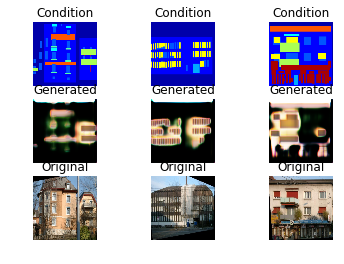

Time for epoch 0 is 91.86723327636719 sec
[Epoch 1] [Batch 0] [D loss: 0.348247] [G loss: 2.053679]


[Epoch 1] [Batch 50] [D loss: 0.007418] [G loss: 0.018158]


[Epoch 1] [Batch 100] [D loss: 0.633080] [G loss: 1.944079]


[Epoch 1] [Batch 150] [D loss: 0.275511] [G loss: 0.058253]


[Epoch 1] [Batch 200] [D loss: 0.251849] [G loss: 0.048837]


[Epoch 1] [Batch 250] [D loss: 0.027661] [G loss: 2.084568]


[Epoch 1] [Batch 300] [D loss: 0.007450] [G loss: 0.193771]


[Epoch 1] [Batch 350] [D loss: 0.611540] [G loss: 1.733366]


[Epoch 1] [Batch 400] [D loss: 0.018676] [G loss: 2.220988]


[Epoch 1] [Batch 450] [D loss: 0.182202] [G loss: 1.182808]


[Epoch 1] [Batch 500] [D loss: 0.504326] [G loss: 0.388070]


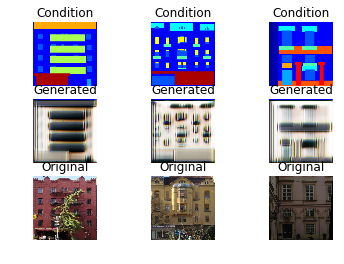

Time for epoch 1 is 78.53655529022217 sec
[Epoch 2] [Batch 0] [D loss: 0.247453] [G loss: 1.367802]


[Epoch 2] [Batch 50] [D loss: 0.025615] [G loss: 0.278353]


[Epoch 2] [Batch 100] [D loss: 0.497004] [G loss: 0.983162]


[Epoch 2] [Batch 150] [D loss: 0.371205] [G loss: 0.150637]


[Epoch 2] [Batch 200] [D loss: 0.211310] [G loss: 0.011184]


[Epoch 2] [Batch 250] [D loss: 0.295774] [G loss: 1.816046]


[Epoch 2] [Batch 300] [D loss: 0.057537] [G loss: 2.754144]


[Epoch 2] [Batch 350] [D loss: 0.414804] [G loss: 0.247590]


[Epoch 2] [Batch 400] [D loss: 0.062817] [G loss: 0.029433]


[Epoch 2] [Batch 450] [D loss: 0.103467] [G loss: 0.074533]


[Epoch 2] [Batch 500] [D loss: 0.032669] [G loss: 0.146824]


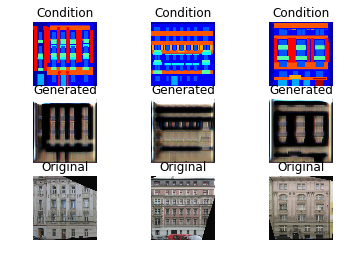

Time for epoch 2 is 78.20887422561646 sec
[Epoch 3] [Batch 0] [D loss: 0.122308] [G loss: 1.941746]


[Epoch 3] [Batch 50] [D loss: 0.449845] [G loss: 1.167771]


[Epoch 3] [Batch 100] [D loss: 0.131649] [G loss: 0.053645]


[Epoch 3] [Batch 150] [D loss: 0.055421] [G loss: 0.009207]


[Epoch 3] [Batch 200] [D loss: 0.172850] [G loss: 0.068365]


[Epoch 3] [Batch 250] [D loss: 0.026117] [G loss: 0.010630]


[Epoch 3] [Batch 300] [D loss: 0.241497] [G loss: 0.072111]


[Epoch 3] [Batch 350] [D loss: 0.184907] [G loss: 0.086329]


[Epoch 3] [Batch 400] [D loss: 0.055991] [G loss: 0.048311]


[Epoch 3] [Batch 450] [D loss: 0.087577] [G loss: 0.013851]


[Epoch 3] [Batch 500] [D loss: 0.008425] [G loss: 0.024309]


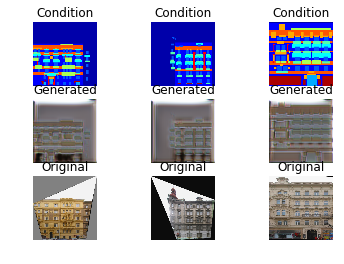

Time for epoch 3 is 78.35302495956421 sec
[Epoch 4] [Batch 0] [D loss: 0.008506] [G loss: 0.039872]


[Epoch 4] [Batch 50] [D loss: 0.036809] [G loss: 0.457790]


[Epoch 4] [Batch 100] [D loss: 0.022724] [G loss: 0.034819]


[Epoch 4] [Batch 150] [D loss: 0.012715] [G loss: 0.011657]


[Epoch 4] [Batch 200] [D loss: 0.066556] [G loss: 0.017838]


[Epoch 4] [Batch 250] [D loss: 0.007775] [G loss: 0.052812]


[Epoch 4] [Batch 300] [D loss: 0.011068] [G loss: 0.017835]


[Epoch 4] [Batch 350] [D loss: 0.016201] [G loss: 0.343429]


[Epoch 4] [Batch 400] [D loss: 0.002758] [G loss: 0.001618]


[Epoch 4] [Batch 450] [D loss: 0.133266] [G loss: 2.399966]


[Epoch 4] [Batch 500] [D loss: 0.021377] [G loss: 1.675407]


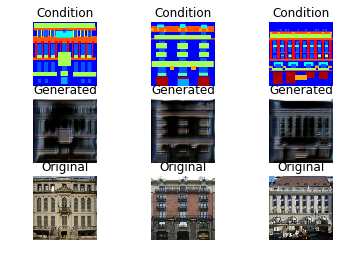

Time for epoch 4 is 78.06847882270813 sec
[Epoch 5] [Batch 0] [D loss: 0.632410] [G loss: 0.110836]


[Epoch 5] [Batch 50] [D loss: 0.010917] [G loss: 0.015774]


[Epoch 5] [Batch 100] [D loss: 0.027495] [G loss: 0.220208]


[Epoch 5] [Batch 150] [D loss: 0.134036] [G loss: 0.045191]


[Epoch 5] [Batch 200] [D loss: 0.032977] [G loss: 0.026691]


[Epoch 5] [Batch 250] [D loss: 0.443130] [G loss: 1.297666]


[Epoch 5] [Batch 300] [D loss: 0.120234] [G loss: 1.029579]


[Epoch 5] [Batch 350] [D loss: 0.157146] [G loss: 0.052383]


[Epoch 5] [Batch 400] [D loss: 0.017141] [G loss: 0.021579]


[Epoch 5] [Batch 450] [D loss: 0.036922] [G loss: 1.373327]


[Epoch 5] [Batch 500] [D loss: 1.268168] [G loss: 1.961089]


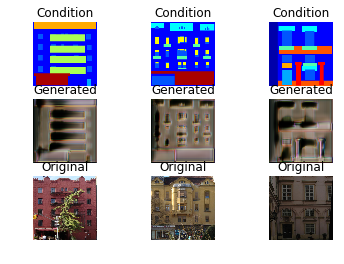

Time for epoch 5 is 78.11464381217957 sec
[Epoch 6] [Batch 0] [D loss: 0.174445] [G loss: 0.644422]


[Epoch 6] [Batch 50] [D loss: 0.042285] [G loss: 0.142991]


[Epoch 6] [Batch 100] [D loss: 0.026091] [G loss: 0.021890]


[Epoch 6] [Batch 150] [D loss: 0.050733] [G loss: 0.097887]


[Epoch 6] [Batch 200] [D loss: 0.017112] [G loss: 0.052163]


[Epoch 6] [Batch 250] [D loss: 0.042029] [G loss: 2.532085]


[Epoch 6] [Batch 300] [D loss: 0.469628] [G loss: 3.632443]


[Epoch 6] [Batch 350] [D loss: 0.272087] [G loss: 0.016666]


[Epoch 6] [Batch 400] [D loss: 0.004350] [G loss: 0.014381]


[Epoch 6] [Batch 450] [D loss: 0.031990] [G loss: 0.004633]


[Epoch 6] [Batch 500] [D loss: 0.021891] [G loss: 0.004862]


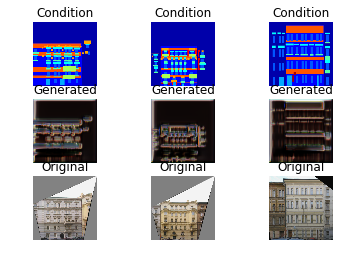

Time for epoch 6 is 78.52092456817627 sec
[Epoch 7] [Batch 0] [D loss: 0.045533] [G loss: 0.017637]


[Epoch 7] [Batch 50] [D loss: 0.009190] [G loss: 0.006299]


[Epoch 7] [Batch 100] [D loss: 0.083375] [G loss: 0.344064]


[Epoch 7] [Batch 150] [D loss: 0.156274] [G loss: 0.082464]


[Epoch 7] [Batch 200] [D loss: 0.089235] [G loss: 0.077361]


[Epoch 7] [Batch 250] [D loss: 0.051994] [G loss: 0.025853]


[Epoch 7] [Batch 300] [D loss: 0.144693] [G loss: 0.833683]


[Epoch 7] [Batch 350] [D loss: 0.129600] [G loss: 0.398878]


[Epoch 7] [Batch 400] [D loss: 0.088062] [G loss: 0.351398]


[Epoch 7] [Batch 450] [D loss: 0.032830] [G loss: 0.062459]


[Epoch 7] [Batch 500] [D loss: 0.027028] [G loss: 0.074532]


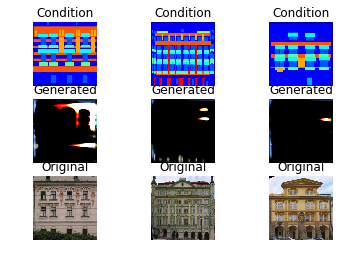

Time for epoch 7 is 78.48967289924622 sec
[Epoch 8] [Batch 0] [D loss: 0.003229] [G loss: 0.028413]


[Epoch 8] [Batch 50] [D loss: 0.854065] [G loss: 3.497716]


[Epoch 8] [Batch 100] [D loss: 0.013752] [G loss: 4.025599]


[Epoch 8] [Batch 150] [D loss: 0.286809] [G loss: 0.183729]


[Epoch 8] [Batch 200] [D loss: 2.122333] [G loss: 1.132616]


[Epoch 8] [Batch 250] [D loss: 0.236898] [G loss: 1.936011]


[Epoch 8] [Batch 300] [D loss: 0.045167] [G loss: 0.003972]


[Epoch 8] [Batch 350] [D loss: 0.028436] [G loss: 0.027625]


[Epoch 8] [Batch 400] [D loss: 0.003193] [G loss: 0.033059]


[Epoch 8] [Batch 450] [D loss: 0.180304] [G loss: 0.032142]


[Epoch 8] [Batch 500] [D loss: 0.011685] [G loss: 0.018349]


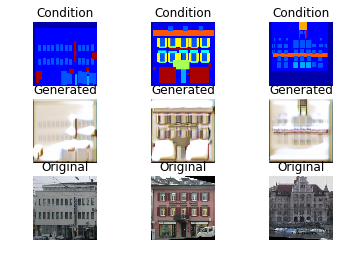

Time for epoch 8 is 78.43061327934265 sec
[Epoch 9] [Batch 0] [D loss: 0.195224] [G loss: 0.011022]


[Epoch 9] [Batch 50] [D loss: 0.056927] [G loss: 0.056847]


[Epoch 9] [Batch 100] [D loss: 0.037407] [G loss: 5.218700]


[Epoch 9] [Batch 150] [D loss: 0.013304] [G loss: 0.010562]


[Epoch 9] [Batch 200] [D loss: 0.379624] [G loss: 0.010501]


[Epoch 9] [Batch 250] [D loss: 0.492562] [G loss: 2.357491]


[Epoch 9] [Batch 300] [D loss: 0.021087] [G loss: 0.057477]


[Epoch 9] [Batch 350] [D loss: 0.619155] [G loss: 0.010859]


[Epoch 9] [Batch 400] [D loss: 0.005862] [G loss: 0.592501]


[Epoch 9] [Batch 450] [D loss: 0.286865] [G loss: 0.143829]


[Epoch 9] [Batch 500] [D loss: 0.003687] [G loss: 0.335511]


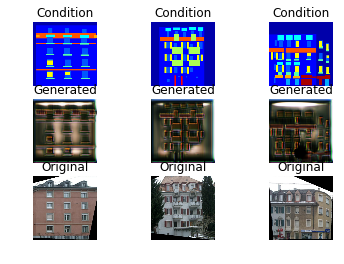

Time for epoch 9 is 78.57098865509033 sec
[Epoch 10] [Batch 0] [D loss: 0.006164] [G loss: 0.016364]


[Epoch 10] [Batch 50] [D loss: 0.002694] [G loss: 0.004672]


[Epoch 10] [Batch 100] [D loss: 0.520548] [G loss: 5.004336]


[Epoch 10] [Batch 150] [D loss: 0.041102] [G loss: 2.276934]


[Epoch 10] [Batch 200] [D loss: 1.084994] [G loss: 0.008245]


[Epoch 10] [Batch 250] [D loss: 0.030293] [G loss: 0.024832]


[Epoch 10] [Batch 300] [D loss: 0.296165] [G loss: 5.482530]


[Epoch 10] [Batch 350] [D loss: 2.517417] [G loss: 1.631059]


[Epoch 10] [Batch 400] [D loss: 0.004958] [G loss: 0.010883]


[Epoch 10] [Batch 450] [D loss: 0.157454] [G loss: 0.022186]


[Epoch 10] [Batch 500] [D loss: 0.009686] [G loss: 0.062210]


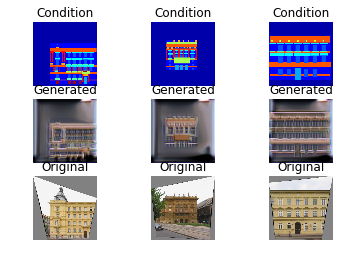

Time for epoch 10 is 78.49248361587524 sec
[Epoch 11] [Batch 0] [D loss: 0.223919] [G loss: 0.004657]


[Epoch 11] [Batch 50] [D loss: 0.666723] [G loss: 0.415410]


[Epoch 11] [Batch 100] [D loss: 0.067232] [G loss: 0.044257]


[Epoch 11] [Batch 150] [D loss: 0.383264] [G loss: 2.706377]


[Epoch 11] [Batch 200] [D loss: 2.708573] [G loss: 0.426280]


[Epoch 11] [Batch 250] [D loss: 0.392892] [G loss: 0.051898]


[Epoch 11] [Batch 300] [D loss: 0.144893] [G loss: 0.005477]


[Epoch 11] [Batch 350] [D loss: 0.293490] [G loss: 0.128550]


[Epoch 11] [Batch 400] [D loss: 0.016451] [G loss: 0.115103]


[Epoch 11] [Batch 450] [D loss: 0.098890] [G loss: 1.284363]


[Epoch 11] [Batch 500] [D loss: 0.003806] [G loss: 0.002590]


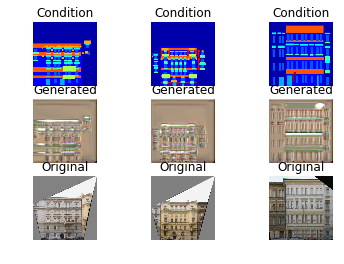

Time for epoch 11 is 78.49498701095581 sec
[Epoch 12] [Batch 0] [D loss: 0.035408] [G loss: 0.001065]


[Epoch 12] [Batch 50] [D loss: 0.007332] [G loss: 0.002155]


KeyboardInterrupt: 

In [5]:
if __name__ == '__main__':
    gan = pix2pix()
    gan.train(epochs=50, batch_size=1)
    